In [1]:
from hydra import initialize, compose
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra

# for import from src
import sys
import os
import torch
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import matplotlib.pyplot as plt

import cv2
from natsort import natsorted
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob



sys.path.insert(0, '../')
from src.models.SRResUNet import SRResUNet

In [2]:
def getConfig(config_path="../configs/"):
    GlobalHydra.instance().clear()
    initialize(version_base=None, config_path=config_path, job_name="notebook") 
    cfg = compose(config_name="config")
    return cfg

In [3]:
expt_dir = "../outputs/2025-05-29/22-54-23/"

image_path = "/mnt/vol3/Datasets/thermal_image/test_image/"
low_res_img_paths = glob.glob(os.path.join(image_path, "webcam", "*.png"))
high_res_img_paths = glob.glob(os.path.join(image_path, "flir", "*.png"))

print("Number of low-res images:", len(low_res_img_paths))
print("Number of high-res images:", len(high_res_img_paths))

config = getConfig(expt_dir)
config

Number of low-res images: 1
Number of high-res images: 1


{'dataset': {'name': 'custom', 'path': 'data/augmented/', 'saved_images': False}, 'model': {'name': 'srresunet', 'pretrained': False, 'in_channels': 3, 'out_channels': 3, 'num_filters': 32, 'num_residuals': 2, 'upscale_factor': 4}, 'training': {'epochs': 100, 'batch_size': 32, 'loss': 'l1', 'optimizer': 'adam', 'learning_rate': 0.0001, 'lr_scheduler_enabled': False, 'lr_step_size': 10, 'lr_gamma': 0.1}, 'other': {'log_print': True, 'wandb': 'tempSuperRes', 'save_val_images_local': True, 'run_testing': True, 'testing_loss': True, 'run_testing_only': False}}

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [5]:
# Load model
model = SRResUNet(
    in_channels=config.model.in_channels,
    out_channels=config.model.out_channels,
    num_filters=config.model.num_filters,
    num_residuals=config.model.num_residuals,
    upscale_factor=config.model.upscale_factor
).to(DEVICE)

# Load checkpoint
checkpoint = torch.load(os.path.join(expt_dir, "models","best_model.pth"), map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


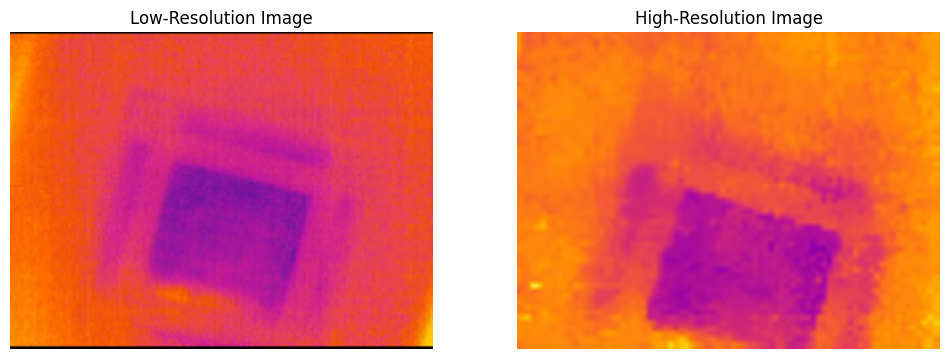

In [6]:
INDEX = 0

# Load and preprocess image
lr_image = Image.open(low_res_img_paths[INDEX]).convert("RGB")
hr_image = Image.open(high_res_img_paths[INDEX]).convert("RGB")

# set lr image dim to 120x160
lr_image = lr_image.resize((160, 120), Image.BICUBIC)

# Display original images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(lr_image)
plt.title("Low-Resolution Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(hr_image)
plt.title("High-Resolution Image")
plt.axis("off")
plt.show()



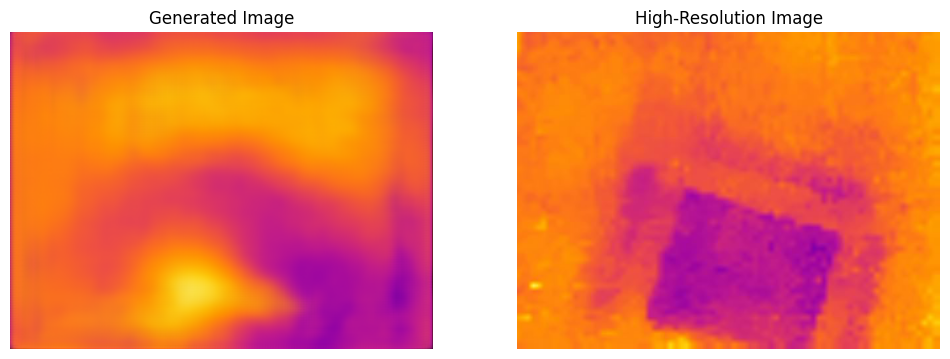

In [7]:
# To tensor and add batch dim
lr_tensor = ToTensor()(lr_image).unsqueeze(0).to(DEVICE)


# Inference
with torch.no_grad():
    sr_tensor = model(lr_tensor)

# Convert to PIL image
sr_image = ToPILImage()(sr_tensor.squeeze(0).cpu().clamp(0, 1))

# Display gen image and ground truth hr image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sr_image)
plt.title("Generated Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(hr_image)
plt.title("High-Resolution Image")
plt.axis("off")
plt.show()